# Import libraries

In [27]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import mannwhitneyu

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score

from transformers import AutoTokenizer


# Import Data

In [2]:
data_list=[]

folder_path='code_classification_dataset'
for filename in os.listdir(folder_path):
    filepath=os.path.join(folder_path, filename)
    with open(filepath, 'r') as f:
        data=json.load(f)
        data_list.append(data)

df=pd.DataFrame(data_list)
df.head()

,prob_desc_time_limit,prob_desc_sample_outputs,src_uid,prob_desc_notes,prob_desc_description,prob_desc_output_spec,prob_desc_input_spec,prob_desc_output_to,prob_desc_input_from,lang,...,difficulty,file_name,code_uid,prob_desc_memory_limit,prob_desc_sample_inputs,exec_outcome,source_code,prob_desc_created_at,tags,hidden_unit_tests
0,1 second,"[""16.000000""]",bb3fc45f903588baf131016bea175a9f,NoteIn the test example we can choose first 4 ...,Iahub has drawn a set of n points in the carte...,Output a single real number — the maximal area...,The first line contains integer n (4 ≤ n ≤ 300...,standard output,standard input,Python 3,...,2100.0,train_048.jsonl,b9da6adb7ff5f00a9127e39974a16d61,256 megabytes,"[""5\n0 0\n0 4\n4 0\n4 4\n2 3""]",PASSED,# calculate convex of polygon v.\n# v is list ...,1377876600,"[geometry, brute force]",
1,2 seconds,"[""1"", ""-1"", ""2"", ""-1"", ""0""]",7898b8258297a6cde8fecb1079172e10,"NoteIn the first test, here is an example plac...",A monopole magnet is a magnet that only has on...,"Output a single integer, the minimum possible ...",The first line contains two integers $$$n$$$ a...,standard output,standard input,PyPy 2,...,2000.0,train_007.jsonl,09b419a2ea7207df6e9f6f972fa83d11,256 megabytes,"[""3 3\n.#.\n###\n##."", ""4 2\n##\n.#\n.#\n##"", ...",PASSED,\n\nfrom math import factorial as fac\nfrom co...,1588775700,"[dsu, constructive algorithms, dfs and similar]",
2,1 second,"[""14"", ""9"", ""3""]",7b12845f668e28b7f18019d5ab5eaec7,NoteIn the first example the optimal sequence ...,Polycarp has prepared $$$n$$$ competitive prog...,Print one integer — the maximum number of prob...,The first line of the input contains one integ...,standard output,standard input,PyPy 3,...,1800.0,train_037.jsonl,99ac0b5c4a37e839f43173d671845752,256 megabytes,"[""18\n2 1 2 10 2 10 10 2 2 1 10 10 10 10 1 1 1...",PASSED,from collections import *\nfrom math import *\...,1542378900,"[sortings, greedy]",
3,4 seconds,"[""3"", ""0"", ""21""]",3875486b0178bf04b3463a15f36f8169,NoteIn the first example three operations are ...,Monocarp has arranged $$$n$$$ colored marbles ...,Print the minimum number of operations Monocar...,The first line contains one integer $$$n$$$ $$...,standard output,standard input,PyPy 3,...,2200.0,train_077.jsonl,13d679e5837ff7ae9285a59d62b8c9a4,256 megabytes,"[""7\n3 4 2 3 4 2 2"", ""5\n20 1 14 10 2"", ""13\n5...",PASSED,# Num of the element\nimport sys\ninput = sys....,1568543700,"[dp, bitmasks]",
4,1 second,"[""3 abc\n2 bc\n1 c\n0 \n1 d"", ""18 abbcd...tw\n...",7d6faccc88a6839822fa0c0ec8c00251,NoteConsider the first example. The longest s...,Some time ago Lesha found an entertaining stri...,In $$$|s|$$$ lines print the lengths of the an...,The only line contains the string $$$s$$$ ($$$...,standard output,standard input,Python 3,...,2700.0,train_011.jsonl,00750c7d58b33d3ac03785c4a39a4ff9,256 megabytes,"[""abcdd"", ""abbcdddeaaffdfouurtytwoo""]",PASSED,s = input().strip();N = len(s)\nif len(s) == 1...,1601827500,"[dp, implementation, greedy, strings]",


# Dataset analysis

### Binarization of the "tags" column

In [3]:
# Delete all tags we aren't trying to predict
tags_to_keep=['math', 'graphs', 'strings', 'number theory', 'trees', 'geometry', 'games', 'probabilities']
df['tags']=df['tags'].apply(lambda taglist: [tag for tag in taglist if tag in tags_to_keep])

# Multilabel binarization
mlb=MultiLabelBinarizer(classes=tags_to_keep)
tags_df=pd.DataFrame(mlb.fit_transform(df['tags']), columns=mlb.classes_)

### Analysis of the "tags" column

In [4]:
# For each tag, computing the number of rows with it
for tag in tags_df.columns:
    count=tags_df[tag].sum()
    percentage=100*count/tags_df.shape[0]
    print(f"Number of problems with the tag '{tag}': {count} ({percentage:.2f}%)")

# Computing number of rows without any of the eight tags
no_tag_count=(tags_df.sum(axis=1)==0).sum()
no_tag_percentage=100*no_tag_count/tags_df.shape[0]
print(f"Number of problems without any of the 8 tags: {no_tag_count} ({no_tag_percentage:.2f}%)")


Number of problems with the tag 'math': 1408 (28.26%)
Number of problems with the tag 'graphs': 542 (10.88%)
Number of problems with the tag 'strings': 422 (8.47%)
Number of problems with the tag 'number theory': 350 (7.03%)
Number of problems with the tag 'trees': 324 (6.50%)
Number of problems with the tag 'geometry': 166 (3.33%)
Number of problems with the tag 'games': 105 (2.11%)
Number of problems with the tag 'probabilities': 92 (1.85%)
Number of problems without any of the 8 tags: 2304 (46.25%)


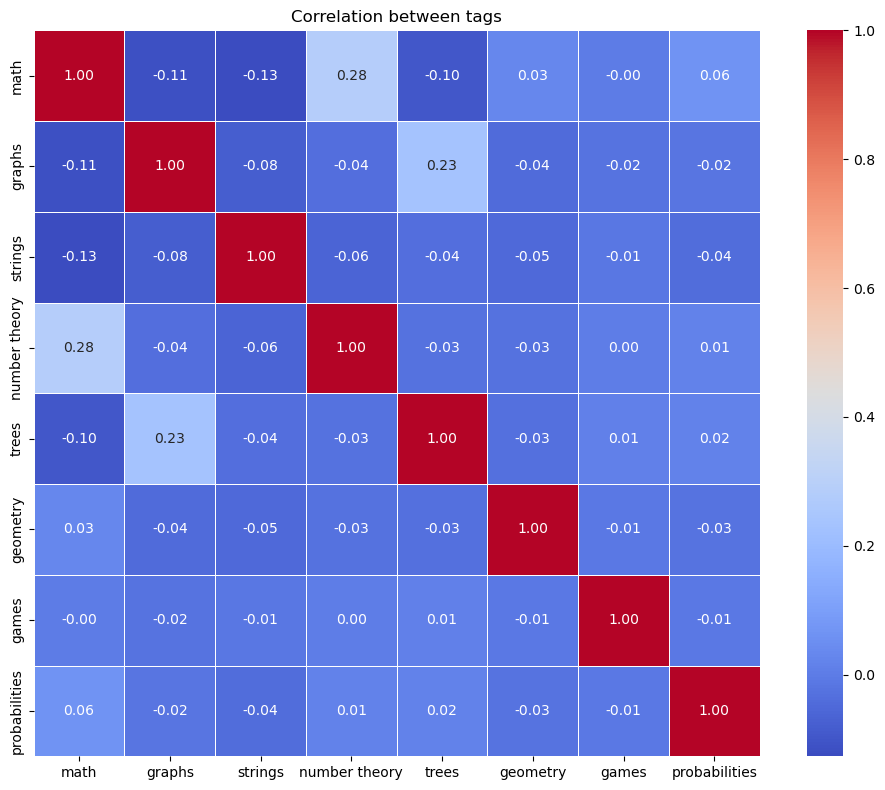

In [5]:
# Computing correlation matrix (between tags)
corr_matrix=tags_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title("Correlation between tags")
plt.tight_layout()
plt.show()


### Analysis of the "prob_desc_description" column

In [6]:
# Putting all the text in lowercase before starting the analysis
df["prob_desc_description"].str.lower()

# Computing the number of problems without a description
missing_values_desc=df['prob_desc_description'].isna().sum()
print(f"Number of missing values in prob_desc_description: {missing_values_desc}")

Number of missing values in prob_desc_description: 0


Average number of words for a problem description: 167
Minimum number of words for a problem description: 10
Maximum number of words for a problem description: 684


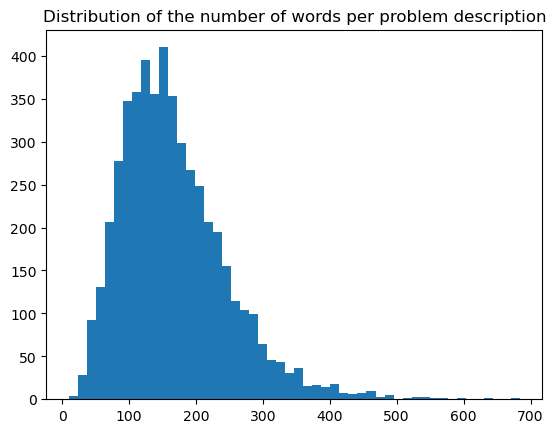

In [7]:
# Statistics on the number of words in problem descriptions
words_per_desc=df['prob_desc_description'].apply(lambda x: len(str(x).split()))
mean_words_per_desc=words_per_desc.mean()
min_words_per_desc=words_per_desc.min()
max_words_per_desc=words_per_desc.max()

print(f"Average number of words for a problem description: {mean_words_per_desc:.0f}")
print(f"Minimum number of words for a problem description: {min_words_per_desc:}")
print(f"Maximum number of words for a problem description: {max_words_per_desc}")

plt.hist(words_per_desc, bins=50)
plt.title('Distribution of the number of words per problem description')
plt.show()

Token indices sequence length is longer than the specified maximum sequence length for this model (788 > 512). Running this sequence through the model will result in indexing errors


Average number of tokens for a problem description: 277
Average number of tokens for a problem description: 13
Average number of tokens for a problem description: 1286
Number of descriptions longer than 512 tokens : 341 (6.84%)


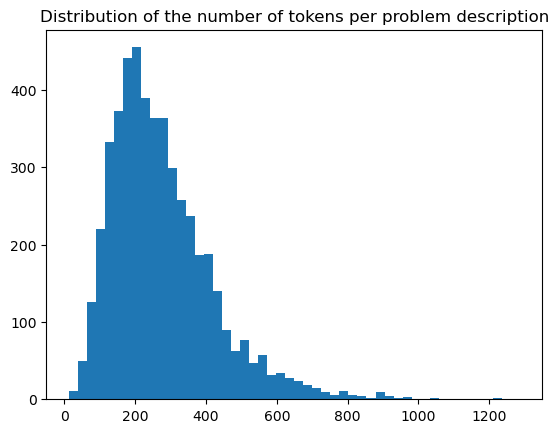

In [8]:
# Importing bert tokenizer
tokenizer=AutoTokenizer.from_pretrained("bert-base-uncased" )

# Statistics on the number of tokens in problem descriptions
tokens_per_desc=df["prob_desc_description"].apply(lambda x: len(tokenizer.tokenize(str(x))))
mean_tokens_per_desc=tokens_per_desc.mean()
min_tokens_per_desc=tokens_per_desc.min()
max_tokens_per_desc=tokens_per_desc.max()
nb_long_desc=sum(tokens_per_desc>512)

print(f"Average number of tokens for a problem description: {mean_tokens_per_desc:.0f}")
print(f"Average number of tokens for a problem description: {min_tokens_per_desc:}")
print(f"Average number of tokens for a problem description: {max_tokens_per_desc}")
print(f"Number of descriptions longer than 512 tokens : {nb_long_desc} ({100*nb_long_desc/len(tokens_per_desc):.2f}%)")

plt.hist(tokens_per_desc, bins=50)
plt.title('Distribution of the number of tokens per problem description')
plt.show()

In [9]:
# Computing the most frequent words per tag

for tag in tags_to_keep:
    df_tag=df.loc[tags_df[tag]==1, "prob_desc_description"]
    vectorizer=CountVectorizer(stop_words='english', max_features=3)
    X_counts=vectorizer.fit_transform(df_tag)
    freqs=X_counts.sum(axis=0).A1
    most_frequent_words=vectorizer.get_feature_names_out()
    print(f"Most frequent words for tag '{tag}': "+", ".join(f"{w} ({f})" for w, f in zip(most_frequent_words, freqs)))


Most frequent words for tag 'math': array (1090), given (816), number (1774)
Most frequent words for tag 'graphs': graph (476), number (579), vertices (412)
Most frequent words for tag 'strings': letters (426), number (454), string (1557)
Most frequent words for tag 'number theory': array (315), integers (326), number (480)
Most frequent words for tag 'trees': tree (798), vertex (522), vertices (441)
Most frequent words for tag 'geometry': coordinates (92), point (206), points (215)
Most frequent words for tag 'games': game (306), play (154), player (228)
Most frequent words for tag 'probabilities': number (93), probability (88), value (61)


### Analysis of the source_code column

In [10]:
# Putting all the text in lowercase before starting the analysis
df["source_code"].str.lower()

# Computing the number of problems without a solution
missing_values_code=df['source_code'].isna().sum()
print(f"Number of missing values in source_code: {missing_values_code}")

Number of missing values in source_code: 0


Average number of words for a code solution: 155
Minimum number of words for a code solution: 2
Maximum number of words for a code solution: 14122


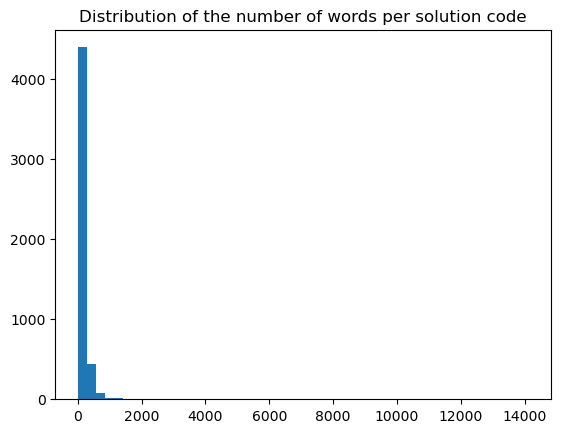

In [11]:
# Statistics on the number of words in solution codes
words_per_code=df['source_code'].apply(lambda x: len(str(x).split()))
mean_words_per_code=words_per_code.mean()
min_words_per_code=words_per_code.min()
max_words_per_code=words_per_code.max()

print(f"Average number of words for a solution code: {mean_words_per_code:.0f}")
print(f"Minimum number of words for a solution code: {min_words_per_code:}")
print(f"Maximum number of words for a solution code: {max_words_per_code}")

plt.hist(words_per_code, bins=50)
plt.title('Distribution of the number of words per solution code')
plt.show()

Token indices sequence length is longer than the specified maximum sequence length for this model (990 > 512). Running this sequence through the model will result in indexing errors


Average number of tokens for a problem description: 683
Average number of tokens for a problem description: 12
Average number of tokens for a problem description: 33109
Number of descriptions longer than 512 tokens : 1872 (37.58%)


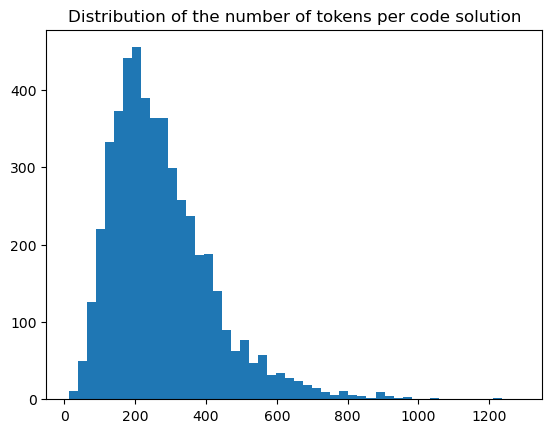

In [99]:
# Statistics on the number of tokens in solution codes
tokenizer_code=AutoTokenizer.from_pretrained("microsoft/codebert-base")
tokens_per_code=df["source_code"].apply(lambda x: len(tokenizer_code.tokenize(str(x))))
mean_tokens_per_code=tokens_per_code.mean()
min_tokens_per_codec=tokens_per_code.min()
max_tokens_per_code=tokens_per_code.max()
nb_long_code=sum(tokens_per_code>512)

print(f"Average number of tokens for a solution code: {mean_tokens_per_code:.0f}")
print(f"Average number of tokens for a solution code: {min_tokens_per_codec:}")
print(f"Average number of tokens for a solution code: {max_tokens_per_code}")
print(f"Number of solution codes longer than 512 tokens : {nb_long_code} ({100*nb_long_code/len(tokens_per_desc):.2f}%)")

plt.hist(tokens_per_desc, bins=50)
plt.title('Distribution of the number of tokens per solution code')
plt.show()

In [13]:
# Checking whether the solution is long or it is an outlier
max_index=words_per_code.idxmax()
row_with_max=df.loc[max_index]

print(row_with_max['source_code'])



# def hcf(a,b):
#     if(b==0):
#         return a
#     else:
#         return hcf(b,a%b)
#
#
# def lcm(a,b):
#     return (a*b)//hcf(a,b)
#
# x=int(input())
# for i in range(x):
#     a,b=map(int,input().split())
#     for i in range(a,b+1):
#         for j in range(a+1,b+1):
#             if(lcm(i,j)*2<=r):
#                 print(lcm(i,j),lcm(i,j)*2)
#                 break
#         else:
#             print('-1 -1')
#         break
#
# # # Two separate lists
# # cars = ["Aston", "Audi", "McLaren"]
# # accessories = ["GPS kit", "Car repair-tool kit"]
# #
# # # Single dictionary holds prices of cars and
# # # its accessories.
# # # First three items store prices of cars and
# # # next two items store prices of accessories.
# # prices = {1:"570000$", 2:"68000$", 3:"450000$",
# #           4:"8900$", 5:"4500$"}
# #
# # # Printing prices of cars
# # for index, c in enumerate(cars, start=1):
# #     print ("Car: %s Price: %s"%(c, prices[index]))
# #
# # # Printing prices of accessorie

### Analysis of the difficulty column

In [14]:
# Computing the number of rows with missing difficulties
missing_values_difficulty=df['difficulty'].isna().sum()
print(f"Number of missing values in difficulty : {missing_values_difficulty} out of {df.shape[0]}")

Number of missing values in difficulty : 39 out of 4982


Average difficulty of problems: 1668
Minimum difficulty of problems: -1
Maximum difficulty of problems: 3500


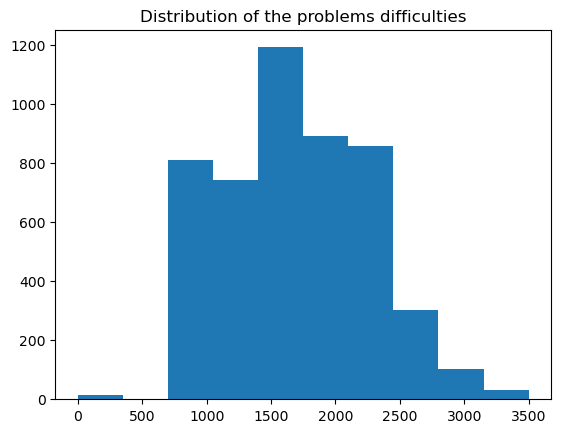

In [15]:
# Statistics on the difficulty of problems
mean_difficulty=df['difficulty'].mean()
min_difficulty=df['difficulty'].min()
max_difficulty=df['difficulty'].max()
print(f"Average difficulty of problems: {mean_difficulty:.0f}")
print(f"Minimum difficulty of problems: {round(min_difficulty)}") 
print(f"Maximum difficulty of problems: {round(max_difficulty)}")

plt.hist(df['difficulty'], bins=10)
plt.title('Distribution of the problems difficulties')
plt.show()

In [16]:
# Deleting rows with no value or -1 in 'difficulty'
valid_rows=df['difficulty'].notna()&(df['difficulty'] != -1)

df=df[valid_rows].reset_index(drop=True)
tags_df=tags_df[valid_rows].reset_index(drop=True)

In [17]:
# Recomputing the average because of deleted rows
dataset_difficulty_mean=df['difficulty'].mean()
print(f"Average difficulty of the dataset: {dataset_difficulty_mean:.0f}")

# Computing one sample t-test for each tag's difficulty to see if they are statistically significant
for tag in tags_to_keep:
    tag_difficulties=df.loc[tags_df[tag]==1,'difficulty']
    without_tag_difficulties=df.loc[tags_df[tag]==0,'difficulty']
    t_stat,p_val=mannwhitneyu(tag_difficulties, without_tag_difficulties)
    print(f"Average difficuty of problems with the tag {tag}: {tag_difficulties.mean():.0f} | p-value: {p_val}")   

Average difficulty of the dataset: 1673
Average difficuty of problems with the tag math: 1636 | p-value: 0.0006092023495999263
Average difficuty of problems with the tag graphs: 2011 | p-value: 4.876677638952301e-53
Average difficuty of problems with the tag strings: 1567 | p-value: 0.00015269636505438664
Average difficuty of problems with the tag number theory: 1786 | p-value: 0.00012407646707756956
Average difficuty of problems with the tag trees: 2054 | p-value: 5.971799403483541e-41
Average difficuty of problems with the tag geometry: 1925 | p-value: 8.357123272260438e-09
Average difficuty of problems with the tag games: 1789 | p-value: 0.04591645110396364
Average difficuty of problems with the tag probabilities: 2236 | p-value: 1.6564770870899389e-21


# Baseline: TF-IDF and logistic regression on prob_desc_description

In [18]:
# Vectorization of prob_desc_description with TF-IDF
vectorizer=TfidfVectorizer(max_features=50000, ngram_range=(1,3))
X_vect=vectorizer.fit_transform(df['prob_desc_description'])
y=tags_df

# Train/test split
X_train, X_test, y_train, y_test=train_test_split(X_vect,y, test_size=0.2, random_state=42)

# Model training
clf=OneVsRestClassifier(LogisticRegression(class_weight='balanced'))
clf.fit(X_train, y_train)

# Evaluation
y_pred=clf.predict(X_test)

# Cumputing the metrics
roc_score_micro=roc_auc_score(y_test, y_pred, average='micro')
f1_micro=f1_score(y_test, y_pred,average='micro')
f1_per_tag=f1_score(y_test, y_pred,average=None)

print(f"F1 score micro:{f1_micro:.2f}")
print(f"ROC_AUC micro:{roc_score_micro:.2f}")
for i, tag in enumerate(mlb.classes_):
    print(f"F1-score for class {tag}:{f1_per_tag[i]:.2f}")


F1 score micro:0.56
ROC_AUC micro:0.77
F1-score for class math:0.55
F1-score for class graphs:0.59
F1-score for class strings:0.64
F1-score for class number theory:0.49
F1-score for class trees:0.63
F1-score for class geometry:0.50
F1-score for class games:0.60
F1-score for class probabilities:0.32
